# Utilizing Text Statistics to Detect SPAM Emails

Our dataset was built using a custom analysis of the emails found in the "eron-spam" corpus. The emails include approximately 19000 emails from Enron Corporation that were relased by the federal government during an investigation into the company as well as approximately 27000 emails that come from a variety of "honeypot" repositories. All emails were collected in their raw, complete form includding associated headers.

The purpose of this analysis is to provide data from which a machine learning model can be produce to automatically detect and remove spam from incomming emails to prevent them from arriving to clients. Spam is pressing issue that wastes computer resources, decreases worker productivity, and is often an infection vector for various malware. Bad actors are continually modifying there strategies in order to evade detection. For instance, it is common practice to add hundreds or even thousands of random dictionary words into portions of the file that aren't directly visible to the user (e.g., HTML comments) in order to make a message appear to have valid content. These continually changing strategies require an adaptive approach to catch new trends as they emerge. Given the amount and pace of change, it is infeasible for software developers and security vendors to react quickly enough. Machine learning, however, is well situated to solve this problem by detecting novel patterns humans may not see (especially given the time restraints) and being able to constantly adapt to new deception patterns.

During the initial preprocessing, we cut down the dataset by removing any headers that had fewer than 10% occurance rates in both spam and legitimate emails (referred to has HAM), combining headers that were addressing the same information but with different names under standardized labels, and removing any headers that would not exist in our application domain. For instance, honeypots may add tracking information and spam analysis while enron emails may include the bcc header (blind carbon copy). When attempting to detect inbound spam neither of these will be available for our model to analyze. In this phase, we soon realized that our spam data was much more diverse in time created, content type, and author than our ham data; which was relatively uniform in its overall construction. To ensure that trends that identify ham were not merely a consequence of our particular dataset, we added approximately 22000 emails to the ham dataset from the Democratic National Committee.

Part of this process is detailed below. As the output shows, some of the emails are excessively large (greater than 5 standard deviations)

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
fileSize=[]
ham_paths = [x for x in glob.iglob('../sizeOfE/raw data/HAM/**', recursive=True) if os.path.isfile(x)]
spam_paths = [x for x in glob.iglob('../sizeOfE/raw data/SPAM/**', recursive=True) if os.path.isfile(x)]
for path in ham_paths:
        fileSize.append(os.path.getsize(path)/1024)
for path in spam_paths:
        fileSize.append(os.path.getsize(path)/1024)
print("average=", np.mean(fileSize))
print("max=", np.max(fileSize))
print("min=", np.min(fileSize))
print("std=", np.std(fileSize))      
df = pd.DataFrame(fileSize,columns=["size"])
df.hist(bins=20)

average= nan


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


ValueError: zero-size array to reduction operation maximum which has no identity

In [3]:
fileSize2=[]
ham_paths2 = [x for x in glob.iglob('../sizeOfE/raw data/HAM/**', recursive=True) if os.path.isfile(x)]
spam_paths2 = [x for x in glob.iglob('../sizeOfE/raw data/SPAM/**', recursive=True) if os.path.isfile(x)]
for path in ham_paths2:
    size = os.path.getsize(path)/1024
    if size < 750:
        fileSize2.append(size)
for path in spam_paths2:
    size = os.path.getsize(path)/1024
    if size < 750:
        fileSize2.append(size)
print("average=", np.mean(fileSize2))
print("max=", np.max(fileSize2))
print("min=", np.min(fileSize2))
print("std=", np.std(fileSize2))      
df2 = pd.DataFrame(fileSize2,columns=["size"])
df2.hist(bins=10)

average= nan


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


ValueError: zero-size array to reduction operation maximum which has no identity

These extremely large emails (greater than 2.5 standard deviations) were not representative of the group and added significant proccessing time to our scripts. Removing them allows CPU time to be better utilize computing additional metrics on the rest of the data

Satisfied with our dataset, we developed a python script that would identify attributes by parsing the raw email headers. We continued by parsing the sender information, subjects, and message payloads utilizing the opensource python modules "textstat" and "fuzzywuzzy" to measure similarities between different sections of the email and general language analysis. Parsing the bodies required filtering them by their content type and content encoding headers. We focused on the "text/plain" and "text/html" content types, decoding any base64 text and extracting strings from any HTML.

In [4]:
df=pd.read_csv('./parsed data/table.csv')
df.head()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67542 entries, 0 to 67541
Data columns (total 10 columns):
multipart_count                         67542 non-null int64
cc                                      67542 non-null bool
kl_divergence_eng_lang_e                67542 non-null float64
frm_fuzz_set_ratio                      67542 non-null float64
is_spam                                 67542 non-null bool
kl_divergence_eng_lang                  67542 non-null float64
organization                            67542 non-null bool
payload_smog_index                      67542 non-null float64
payload_coleman_liau_index              67542 non-null float64
payload_dale_chall_readability_score    67542 non-null float64
dtypes: bool(3), float64(6), int64(1)
memory usage: 3.8 MB


,multipart_count,cc,kl_divergence_eng_lang_e,frm_fuzz_set_ratio,is_spam,kl_divergence_eng_lang,organization,payload_smog_index,payload_coleman_liau_index,payload_dale_chall_readability_score
0,0,True,11.453942,93.0,False,16.524546,False,9.6,13.29,10.14
1,0,True,11.115775,100.0,False,16.036674,False,11.2,20.42,10.03
2,0,True,11.793050,100.0,False,17.013774,False,6.9,10.36,9.59
3,0,True,11.647540,100.0,False,16.803848,False,10.4,13.63,10.18
4,0,True,10.775279,92.0,False,15.545441,False,11.8,22.85,10.53


In [5]:
spam_t=0
spam_f=0
ham_t=0
ham_f=0
for i in range(df.cc.count()):
    if df.is_spam[i]:
        if df.cc[i]:
            spam_t += 1
        else:
            spam_f += 1
    else:
        if df.cc[i]:
            ham_t += 1
        else:
            ham_f += 1

sb.barplot( x=['SPAM+CC','SPAM-CC','HAM+CC','HAM-CC'],y=[spam_t, spam_f, ham_t, ham_f])

We decided to create a heatmap of the correlation plots to see what attributes of our data correlate well with spam. We found that cc has a very strong negative correlation(-.75) with spam. We expected that because cc isn’t very likely to appear in SPAM. We also found that spam has a negative correlation with whether or not an email was sent from an organization(.53), which makes sense because a lot of our email data set included emails from the DNC. The smog index we calculated for the payload is positively correlated with spam, which means that spam has a higher score on the smog index. This means that SPAM is likely be harder to read than HAM. We won’t mention the other correlations because most of the attributes that are correlated measure scores for the same attributes using different formulas.

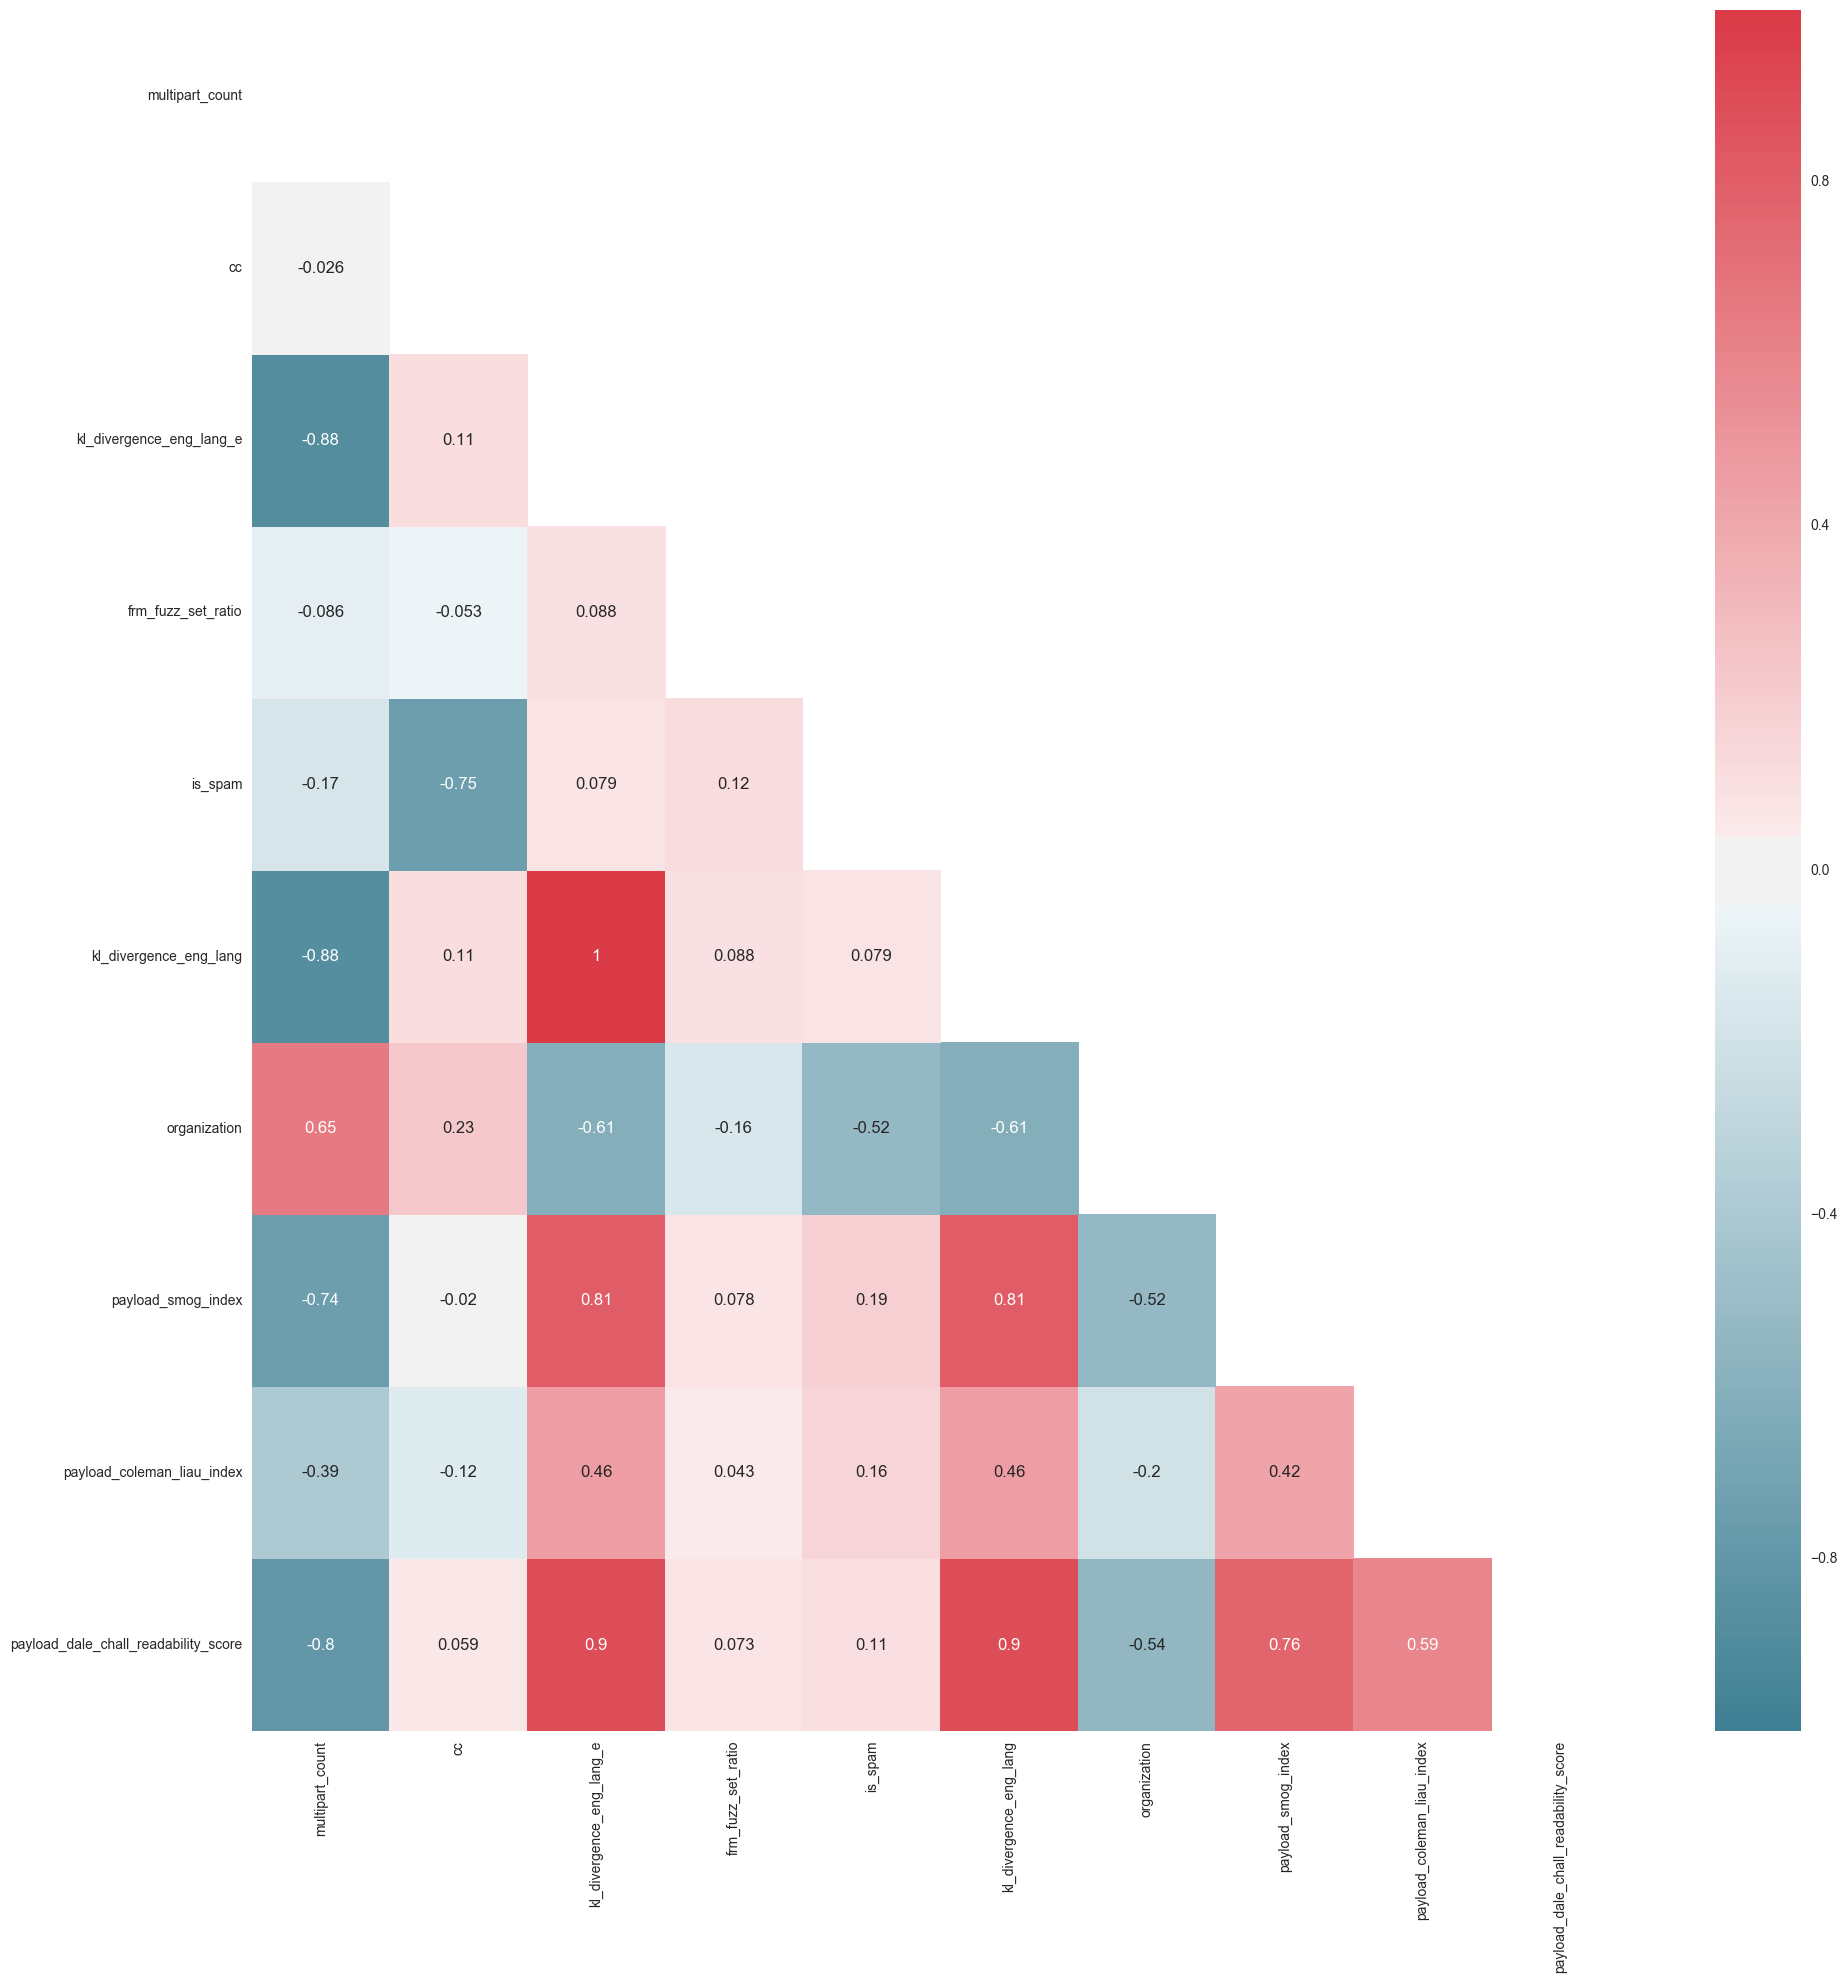

In [5]:
sb.set(style="whitegrid") # one of the many styles to plot using
cmap = sb.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(20, 20))

corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sb.heatmap(corr, mask=mask, cmap=cmap, annot=True)
f.tight_layout()

In [11]:
sb.violinplot( x="is_spam",y="payload_smog_index" , data=df, 
               split=True, inner="quart")

In [10]:
spam_t=0
spam_f=0
ham_t=0
ham_f=0
for i in range(df.cc.count()):
    if df.is_spam[i]:
        if df.organization[i]:
            spam_t += 1
        else:
            spam_f += 1
    else:
        if df.organization[i]:
            ham_t += 1
        else:
            ham_f += 1

sb.barplot( x=['SPAM+ORG','SPAM-ORG','HAM+ORG','HAM-ORG'],y=[spam_t, spam_f, ham_t, ham_f])

In [6]:
no = 0
li = 0
hi = 0
me = 0
lo = 0
inv= 0

for i in range(df.cc.count()):
    if 'no' in df.importance[i]:
        no += 1
    elif 'li' in df.importance[i]:
        li += 1
    elif 'hi' in df.importance[i]:
        hi += 1
    elif 'me' in df.importance[i]:
        me += 1
    elif 'lo' in df.importance[i]:
        lo += 1
    elif 'inv' in df.importance[i]:
        inv += 1
    else:
        pass # print(df.importance[i])

sb.barplot( x=['none','list','high','medium','low', 'invalid'],y=[no,li,hi,me,lo,inv])

AttributeError: 'DataFrame' object has no attribute 'importance'

One feature that is currently missing from our dataset is an inverse frequency table of the words found in each message. Casual observation shows us that spam emails contain higher rates of very rare words and lower rates of common words. This is a result of them often being constructed with poor grammar, selling unusual products, using slang to market them, and including hidden patches of text with strange scentence of random nouns. Computing a frequency table for each method and comparing it with an english word frequency table from a large corpus of print and online media has the potential to identify these charactersitics of spam relatively simply. These tables are available online and would be trivial to include in our statistic computations.

In [3]:
freq_table = {}
word_count = 0
total_occurrences = 0
with open('lib data/count_1w.txt') as freq:
    for line in freq:
        name, count = line.partition('\t')[::2]
        count = float(count[:-1])
        freq_table[name.strip()] = count
        word_count += 1
        total_occurrences += count

freq_mean = np.mean(list(freq_table.values()))
freq_std = np.std(list(freq_table.values()))

In [4]:
temp = pd.Series(list(freq_table.values()))
temp = pd.DataFrame({'x': temp.index,'y': temp})

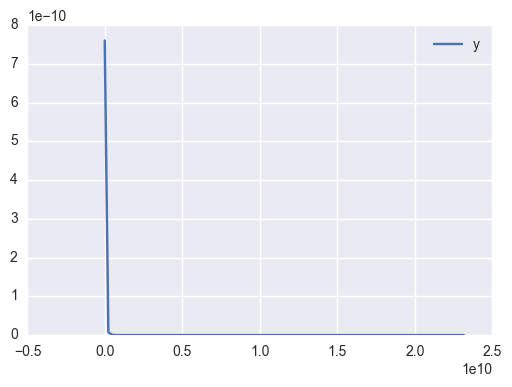

In [5]:
sb.kdeplot(temp.y)

In [5]:
sb.kdeplot(temp.sample(frac=0.01).y)

In [6]:
    from scipy import log
    from scipy.special import zeta
    from scipy.optimize import bisect 

    xmin = 1
    x = temp.y
    n = len(temp.y)

    def log_zeta(x):
        return log(zeta(x, 1))

    def log_deriv_zeta(x):
        h = 1e-5
        return (log_zeta(x+h) - log_zeta(x-h))/(2*h)

    t = -sum( log(x/xmin) )/n
    def objective(x):
        return log_deriv_zeta(x) - t

    a, b = 1.01, 10
    alpha_hat = bisect(objective, a, b, xtol=1e-6)
    print(alpha_hat)

1.0853704565763473


In [7]:
    from scipy.special import zeta
    from scipy import sqrt

    def zeta_prime(x, xmin=1):
        h = 1e-5
        return (zeta(x+h, xmin) - zeta(x-h, xmin))/(2*h)

    def zeta_double_prime(x, xmin=1):
        h = 1e-5
        return (zeta(x+h, xmin) -2*zeta(x,xmin) + zeta(x-h, xmin))/h**2

    def sigma(n, alpha_hat, xmin=1):
        z = zeta(alpha_hat, xmin)
        temp = zeta_double_prime(alpha_hat, xmin)/z
        temp -= (zeta_prime(alpha_hat, xmin)/z)**2
        return 1/sqrt(n*temp)

    print( sigma(n, alpha_hat) )

0.000147962606855


In [ ]:
from scipy.stats import zipf
#zipf.pmf(12000, sigma(n, alpha_hat))
prob = zipf.cdf(x, a)
print(np.close(x[0], zipf.ppf(prob, a)))

In [ ]:
print(np.close(x, zipf.ppf(prob, a)))

In [ ]:
sb.violinplot( y='y', data=temp.sample(frac=0.005), 
               split=False, inner="quart")

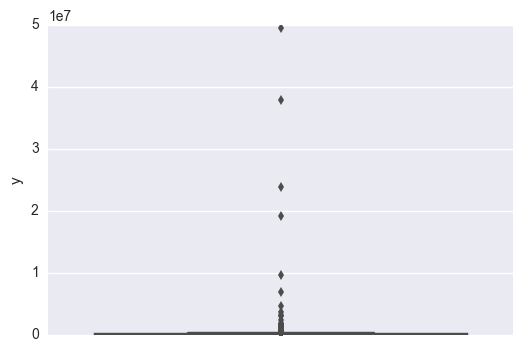

In [23]:
sb.boxplot(y='y', data=temp.sample(frac=0.001))

## Preprocessing Code

Our preprocessing consisted of three steps. Ingesting raw emails into a dictionary of email objects, filtering and manipulating the email objects, and computing statistics from them to be exported to a csv. These steps are completed by the scripts convert_to_email.py, build_table.py,  compute_stats.py respectively and are included below

In [ ]:

from email.parser import Parser
import glob
import os
import pickle
import datetime


def cout(text):
    print('[{:%Y-%m-%d %H:%M:%S}] %s'.format(datetime.datetime.now()) % text)

cout('Getting file paths')

# Get file names
ham_paths = [x for x in glob.iglob('raw data/HAM/**', recursive=True) if os.path.isfile(x)]
spam_paths = [x for x in glob.iglob('raw data/SPAM/**', recursive=True) if os.path.isfile(x)]

cout('Allocating Memory')

emails = {'ham': len(ham_paths)*[None], 'spam': len(spam_paths)*[None]}

cout('Load and parse HAM')

# Load ham files
idx = 0
for path in ham_paths:
    with open(path, encoding='latin1') as fp:
        emails['ham'][idx] = Parser().parse(fp)
        idx += 1

cout('Load and parse SPAM')

# Load spam files
idx = 0
for path in spam_paths:
    with open(path, encoding='latin1') as fp:
        emails['spam'][idx] = Parser().parse(fp)
        idx += 1

cout('Saving to disk')

# Save to disk
with open('parsed data/emails.pkl', 'wb') as f:
    pickle.dump(emails, f, pickle.HIGHEST_PROTOCOL)

cout('Process Completed')


In [ ]:

import pickle
import datetime
import csv
import re
import copy
from bs4 import BeautifulSoup


def cout(text):
    print('[{:%Y-%m-%d %H:%M:%S}] %s'.format(datetime.datetime.now()) % text)


def post_filter_header_frequency_analysis(data, file_name, keys):
    header_counts = {}
    for h in keys:
        header_counts[h] = {'Header': h, 'SPAM Count': 0, 'HAM Count': 0}

    cout('Counting occurrences of header labels')

    for row in data:
        for h in row:
            if h in keep_headers and row[h] is not None:
                header_counts[h]['SPAM Count' if row['is_spam'] else 'HAM Count'] += 1

    cout('Saving occurrence counts to disk')

    with open('parsed data/%s.csv' % file_name, 'w') as output_file:
        dict_writer = csv.DictWriter(output_file, ['Header', 'SPAM Count', 'HAM Count'])
        dict_writer.writeheader()
        dict_writer.writerows(header_counts.values())


def header_frequency_analysis(data, file_name, keys):
    header_counts = {}
    for h in keys:
        header_counts[h] = {'Header': h, 'SPAM Count': 0, 'HAM Count': 0}

    cout('Counting occurrences of header labels from SPAM')

    for datum in data['spam']:
        for d in datum:
            header_counts[d]['SPAM Count'] += 1

    cout('Counting occurrences of header labels from HAM')

    for datum in data['ham']:
        for d in datum:
            header_counts[d]['HAM Count'] += 1

    cout('Saving occurrence counts to disk')

    with open('parsed data/%s.csv' % file_name, 'w') as output_file:
        dict_writer = csv.DictWriter(output_file, ['Header', 'SPAM Count', 'HAM Count'])
        dict_writer.writeheader()
        dict_writer.writerows(header_counts.values())

cout('Loading pickle file')

with open('parsed data/emails.pkl', 'rb') as f:
    emails = pickle.load(f)

headers = set()

cout('Extracting unique header labels from HAM')

for email in emails['ham']:
    for key in email:
        headers.add(key)

cout('Extracting unique header labels from SPAM')

for email in emails['spam']:
    for key in email:
        headers.add(key)

cout('Starting pre-filter header frequency analysis')
header_frequency_analysis(emails, 'pre_filter_headers', headers)

# Contains header-regex key-value pairs that will be kept after filtering
keep_headers = {
    'from': re.compile('from|.*sender'),                                     # Categorical (match, no-match, n/a)
    'subject': re.compile('subject'),
    'reply_to': re.compile('^(?!in).*reply.*to.*$|returnpath'),              # Categorical (match, no-match, n/a)
    'importance': re.compile('.*priority.*|.*importance.*|.*precedence.*'),  # Categorical
    'cc': re.compile('cc'),                                                  # Bool for has header
    'organization': re.compile('.*organization.*')                           # Bool for has header
}

cout('Building table template (layout)')

# Initialize template with all None values
row_template = {
    'is_spam': None,
    'from': set(),
    'subject': None,
    'reply_to': set(),
    'importance': set(),
    'cc': False,
    'organization': False
}

# Allocate table of templates
table = (len(emails['spam']) + len(emails['ham'])) * [None]

cout('Filtering & combining headers / importing HAM into table')


def html2txt(html):
    text = ''

    try:
        soup = BeautifulSoup(html, "lxml")

        # kill all script and style elements
        for script in soup(["script", "style"]):
            script.extract()  # rip it out

        # get text
        text = soup.get_text()

        # break into lines and remove leading and trailing space on each
        lines = (line.strip() for line in text.splitlines())
        # break multi-headlines into a line each
        chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
        # drop blank lines
        text = '\n'.join(chunk for chunk in chunks if chunk)
    except:
        print('ERROR: Failed to parse as HTML => %s' % html)

    return text

import base64


def flatten(msg):
    if isinstance(msg, str):
        return msg

    ret = ''

    try:
        for m in msg:
            payload = m.get_payload()
            if isinstance(payload, list):
                #ret += flatten(payload)
                continue

            tmp = m.get('Content-Type')

            if tmp is None or 'text' in tmp:
                if m.get('Content-Transfer-Encoding') == 'base64':
                    html = base64.b64decode(payload)
                ret += str(payload)
            elif 'text/html' in tmp:
                if m.get('Content-Transfer-Encoding') == 'base64':
                    payload = base64.b64decode(payload)
                ret += html2txt(payload)
    except:
        print('ERROR: Failed to parse => %s' % msg)

    return ret

char_filter = re.compile('[^a-z]')

idx = 0

for email in emails['ham']:
    table[idx] = copy.deepcopy(row_template)
    table[idx]['is_spam'] = False

    # Find relevant headers
    for header in email:
        for key in keep_headers:
            # Check lowercase, alphabet only characters against patterns
            tmp = char_filter.sub('', header.lower())
            if keep_headers[key].search(tmp):
                if table[idx][key] is None:
                    table[idx][key] = email[header]
                elif table[idx][key] is False:
                    table[idx][key] = True
                elif table[idx][key] is True:
                    pass
                elif isinstance(table[idx][key], set):
                    table[idx][key].add(email[header])

    table[idx]['multipart_count'] = 0 if not email.is_multipart() else len(email.get_payload())
    table[idx]['payload'] = flatten(email.get_payload())

    idx += 1

cout('Filtering & combining headers / importing SPAM into table')

for email in emails['spam']:
    table[idx] = copy.deepcopy(row_template)
    table[idx]['is_spam'] = True

    # Find relevant headers
    for header in email:
        for key in keep_headers:
            # Check lowercase, alphabet only characters against patterns
            tmp = char_filter.sub('', header.lower())
            if keep_headers[key].search(tmp):
                if table[idx][key] is None:
                    table[idx][key] = email[header]
                elif table[idx][key] is False:
                    table[idx][key] = True
                elif table[idx][key] is True:
                    pass
                elif isinstance(table[idx][key], set):
                    table[idx][key].add(email[header])

    table[idx]['multipart_count'] = 0 if not email.is_multipart() else len(email.get_payload())
    table[idx]['payload'] = flatten(email.get_payload())

    idx += 1

cout('Saving to disk')

# Save to disk
with open('parsed data/table.pkl', 'wb') as f:
    pickle.dump(table, f, pickle.HIGHEST_PROTOCOL)

cout('Starting post-filter header frequency analysis')
post_filter_header_frequency_analysis(table, 'post_filter_headers', keep_headers.keys())


In [ ]:

import pickle
import datetime
import csv
import re
from textstat.textstat import textstat
from fuzzywuzzy import fuzz
from multiprocessing import Pool


def cout(text):
    print('[{:%Y-%m-%d %H:%M:%S}] %s'.format(datetime.datetime.now()) % text)

cout('Loading pickle file')

with open('parsed data/table.pkl', 'rb') as f:
    table = pickle.load(f)

numeric = re.compile('.*[0-9].*')

unique = set()


def calc_stat(row):
    # Analyze from and reply_to data
    send_reply_data = list(row.pop('from', {}) | row.pop('reply_to', {}))

    frm_fuzz_set = 0
    n = 0

    if not row['is_spam']:
        pass

    for i in range(len(send_reply_data)-1):
        for j in range(i+1, len(send_reply_data)):
            frm_fuzz_set += fuzz.token_set_ratio(send_reply_data[i], send_reply_data[j])
            n += 1

    row['frm_fuzz_set_ratio'] = frm_fuzz_set / n if n != 0 else 100

    # Analyze importance data
    importance = row.pop('importance', None)

    # Filter round
    importance = set(filter(lambda x: not numeric.match(x), importance))

    # Conversion round
    if any(('list' in x or 'ulk' in x) for x in importance):
        importance = {'list'}
    elif any(('ormal' in x or 'non-urgent' in x) for x in importance):
        importance = {'medium'}
    elif any(('igh' in x or 'rgent' in x) for x in importance):
        importance = {'high'}
    elif any('junk' in x for x in importance):
        importance = {'low'}
    elif len(importance) == 0 or importance == {''}:
        importance = {'none'}
    elif all('$' in x or 'user' in x or 'auto' in x for x in importance):
        importance = {'invalid'}
    else:
        importance = {importance.pop().lower()}

    row['importance'] = ', '.join(importance)

    # Analyze subject
    subject = row.pop('subject', None)

    def set_neg_1():
        row['subject_flesch_reading_ease'] = -1
        row['subject_smog_index'] = -1
        row['subject_flesch_kincaid_grade'] = -1
        row['subject_coleman_liau_index'] = -1
        row['subject_automated_readability_index'] = -1
        row['subject_dale_chall_readability_score'] = -1
        row['subject_difficult_words'] = -1
        row['subject_linsear_write_formula'] = -1
        row['subject_gunning_fog'] = -1

    if subject is not None and subject != '':
        try:
            row['subject_flesch_reading_ease'] = textstat.flesch_reading_ease(subject)
            row['subject_smog_index'] = textstat.smog_index(subject)
            row['subject_flesch_kincaid_grade'] = textstat.flesch_kincaid_grade(subject)
            row['subject_coleman_liau_index'] = textstat.coleman_liau_index(subject)
            row['subject_automated_readability_index'] = textstat.automated_readability_index(subject)
            row['subject_dale_chall_readability_score'] = textstat.dale_chall_readability_score(subject)
            row['subject_difficult_words'] = textstat.difficult_words(subject)
            row['subject_linsear_write_formula'] = textstat.linsear_write_formula(subject)
            row['subject_gunning_fog'] = textstat.gunning_fog(subject)
        except:
            set_neg_1()
    else:
        set_neg_1()

    # Analyze payload(s)
    payload = row.pop('payload', None)

    def set_neg_1p():
        row['payload_flesch_reading_ease'] = -1
        row['payload_smog_index'] = -1
        row['payload_flesch_kincaid_grade'] = -1
        row['payload_coleman_liau_index'] = -1
        row['payload_automated_readability_index'] = -1
        row['payload_dale_chall_readability_score'] = -1
        row['payload_difficult_words'] = -1
        row['payload_linsear_write_formula'] = -1
        row['payload_gunning_fog'] = -1

    if payload is not None and isinstance(payload, str) and payload != '':
        try:
            #print()
            row['payload_flesch_reading_ease'] = textstat.flesch_reading_ease(payload)
            row['payload_smog_index'] = textstat.smog_index(payload)
            row['payload_flesch_kincaid_grade'] = textstat.flesch_kincaid_grade(payload)
            row['payload_coleman_liau_index'] = textstat.coleman_liau_index(payload)
            row['payload_automated_readability_index'] = textstat.automated_readability_index(payload)
            row['payload_dale_chall_readability_score'] = textstat.dale_chall_readability_score(payload)
            row['payload_difficult_words'] = textstat.difficult_words(payload)
            row['payload_linsear_write_formula'] = textstat.linsear_write_formula(payload)
            row['payload_gunning_fog'] = textstat.gunning_fog(payload)
        except:
            set_neg_1p()
    else:
        set_neg_1p()

    return row

cout('Computing %d row statistics using %d processes' % (len(table), 4))

pool = Pool(processes=7)
table = pool.map(calc_stat, table)

cout('Saving table to disk as CSV')

# Save to disk as CSV
with open('parsed data/table.csv', 'w') as output_file:
    dict_writer = csv.DictWriter(output_file, table[0].keys())
    dict_writer.writeheader()

    for row in table:
        dict_writer.writerow({k: v.encode('utf-8') if isinstance(v, str) else v for k, v in row.items()})
